In [102]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Objetivo
En Red con max ya se logró una red que predice los valores máximos de longitud de onda e índice de absorción. Esta red no nada más predecirá elñ punto máximo sinó que buscaremos que prediga todo el espectro de longitudes de onda, es decir de 300 a 900nm. Como resultado esperamos una gráfica

In [103]:
files = [file for file in os.listdir('./parametros')]

param = pd.DataFrame()
for file in files:
  df = pd.read_csv('./parametros/'+file)
  param = pd.concat([param, df], axis= 0)

In [104]:
param

,Longitud de onda,Índice de absorción,Fracvol,Radio (nm),Espesor de la película (nm)
0,301,0.016685,1,10,100
1,302,0.016167,1,10,100
2,303,0.015703,1,10,100
3,304,0.015290,1,10,100
4,305,0.014916,1,10,100
...,...,...,...,...,...
19195,896,0.002255,1,9,120
19196,897,0.002257,1,9,120
19197,898,0.002258,1,9,120
19198,899,0.002260,1,9,120


In [105]:
# Seleccionar las columnas de entrada y salida
X = ['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)','Longitud de onda']
y = ['Índice de absorción']

# Dividir los datos en conjuntos de entrenamiento y prueba 
X_train, X_test, y_train, y_test = train_test_split(param[X], param[y], test_size=0.2, random_state=42)

Dividir los datos en características (X) y etiquetas (y)

In [106]:
X = df.drop('Índice de absorción', axis=1).values
y = df['Índice de absorción'].values

Normalizar los datos usando MinMaxScaler


In [107]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
y_normalized = scaler.fit_transform(y.reshape(-1, 1))

Dividir los datos en conjuntos de entrenamiento y prueba

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

Arquitectura red

In [109]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Capa de salida para la predicción del índice de absorción
])

Compilación y entrenamiento

In [110]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

Predicciones normalizadas

In [111]:
predictions_normalized = model.predict(X_test)

120/120 [==============================] - 0s 486us/step


Desnormalización

In [112]:
predictions_denormalized = scaler.inverse_transform(predictions_normalized)
y_test_denormalized = scaler.inverse_transform(y_test)

Calcular el error absoluto medio (MAE) en la escala original

In [113]:
mae = mean_absolute_error(y_test_denormalized, predictions_denormalized)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

Mean Absolute Error (MAE): 0.0001


In [114]:
# Calcular el error medio absoluto (MAE)
mae = mean_absolute_error(y_test_denormalized, predictions_denormalized)
print('MAE:', mae)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test_denormalized, predictions_denormalized)
print('MSE:', mse)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y_test_denormalized, predictions_denormalized)
print('R^2:', r2)

MAE: 6.471029486360713e-05
MSE: 9.124350532788351e-09
R^2: 0.9991089738428549


Imagina que estás tratando de predecir cuántos puntos obtendrás en un examen, pero tu estimación podría ser un poco diferente a la realidad. La gráfica "Valores Predichos vs. Valores Reales" compara tus predicciones con los resultados reales de los exámenes.

En la gráfica:

El eje horizontal (eje x) representa los resultados reales que obtuviste en los exámenes.
El eje vertical (eje y) representa las estimaciones que hiciste antes del examen.
Cada punto en la gráfica representa un examen individual:

Si tus predicciones fueran siempre perfectas y coincidieran exactamente con tus resultados reales, todos los puntos estarían en una línea recta que sube diagonalmente desde la esquina inferior izquierda hasta la esquina superior derecha. Esa sería la "Línea de Identidad".
Sin embargo, en la realidad, es probable que algunas de tus predicciones sean un poco más altas o más bajas que tus resultados reales. Esto significa que los puntos no caerán exactamente en la Línea de Identidad.
La gráfica te muestra cómo se comparan tus predicciones con los resultados reales. Si la mayoría de los puntos están cerca de la Línea de Identidad, significa que tus predicciones son bastante acertadas. Si los puntos están muy dispersos y alejados de la línea, podría significar que tus predicciones no son muy precisas.

En resumen, la gráfica te ayuda a ver cuán cerca están tus estimaciones de la realidad. Cuanto más cerca estén los puntos de la Línea de Identidad, mejor es tu capacidad para predecir con precisión.

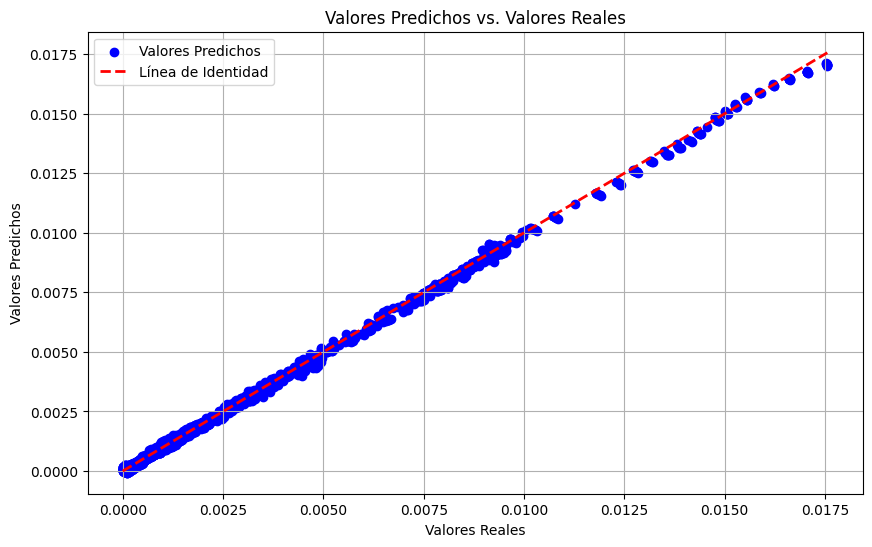

In [115]:
# Crear una figura
plt.figure(figsize=(10, 6))

# Graficar valores predichos vs. valores reales
plt.scatter(y_test_denormalized, predictions_denormalized, color='blue', label='Valores Predichos')
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], [y_test_denormalized.min(), y_test_denormalized.max()], color='red', linestyle='--', linewidth=2, label='Línea de Identidad')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Predichos vs. Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

Imagina que estás enseñándole a un robot a hacer una tarea, como adivinar cuántas manzanas hay en una canasta. Cuando el robot adivina mal, cometemos un error. El objetivo es enseñar al robot a hacerlo mejor con el tiempo.

La gráfica es como un dibujo que muestra cómo el robot mejora su habilidad para adivinar la cantidad de manzanas a medida que practica más. Hay dos líneas en el dibujo:

Línea Azul: Muestra cuán equivocado estaba el robot en sus adivinanzas mientras practicaba. Al principio, cuando el robot recién comienza a aprender, comete muchos errores y esta línea baja rápidamente.

Línea Naranja: Muestra cuán equivocado estaba el robot en una prueba que nunca había visto antes. Es como si le pidieras al robot adivinar la cantidad de manzanas en una canasta que nunca había visto. Al principio, comete muchos errores, pero luego mejora a medida que practica más.

El objetivo es que ambas líneas bajen y estén cerca una de la otra. Esto significa que el robot está aprendiendo y adivinando bien tanto en las prácticas como en las pruebas nuevas. Si las líneas empiezan a alejarse, puede ser una señal de que el robot se está concentrando demasiado en aprender las adivinanzas que ya conoce y se está olvidando de cómo adivinar nuevas adivinanzas. Queremos que el robot sea bueno en ambas cosas.

Así que, en resumen, la gráfica nos muestra cómo el robot está mejorando a medida que practica y cómo se está comportando en cosas nuevas que nunca antes había visto. Queremos que las líneas sean bajitas y cercanas para que el robot sea un buen adivinador en general.

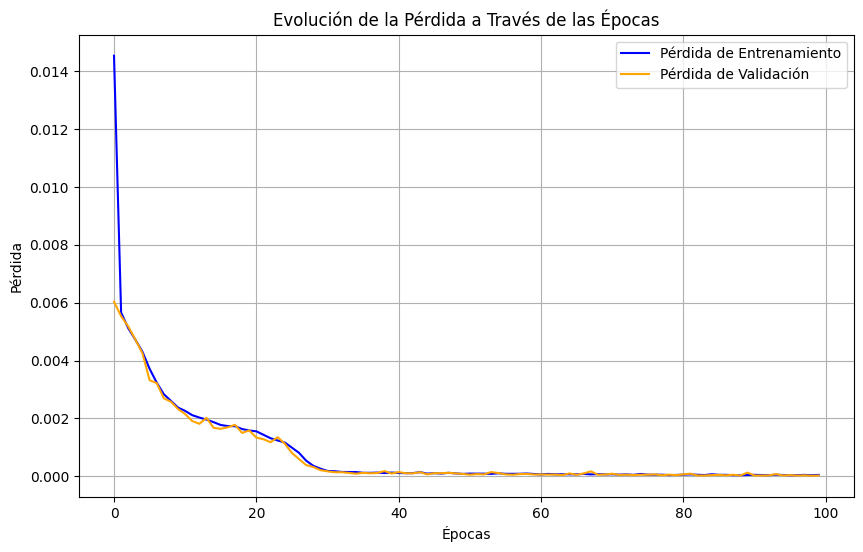

In [116]:
# Obtener las pérdidas de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear una figura
plt.figure(figsize=(10, 6))

# Graficar las pérdidas de entrenamiento y validación
plt.plot(train_loss, label='Pérdida de Entrenamiento', color='blue')
plt.plot(val_loss, label='Pérdida de Validación', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida a Través de las Épocas')
plt.legend()
plt.grid(True)
plt.show()

# Guardando modelo

In [117]:
model.save('generadorPuntos2.h5')